In [59]:
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib
import numpy as np
import torchvision.transforms as Transforms

print(torch.__version__)

2.0.1+cu117


In [17]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/buildozer-1.5.1.dev0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/sh-2.0.4-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [18]:
from torchsummary import summary
matplotlib.rcParams['figure.facecolor']= 'white'

In [28]:
train_df = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

In [35]:
print(train_df.head() , '\n',"shope of the train_set is : \n", train_df.shape, "Info : \n", test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226  

In [39]:
print(test_df.head() , '\n',"shope of the train_set is : \n", test_df.shape, "Info : \n", test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     206     207     209     210     209   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   
3     210  ...       154       248       247       248       253       236  

In [44]:
import string 

alpha_dict = {idx:letter for idx, letter in enumerate(string.ascii_lowercase)}
alpha_dict


{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z'}

<Axes: xlabel='label', ylabel='count'>

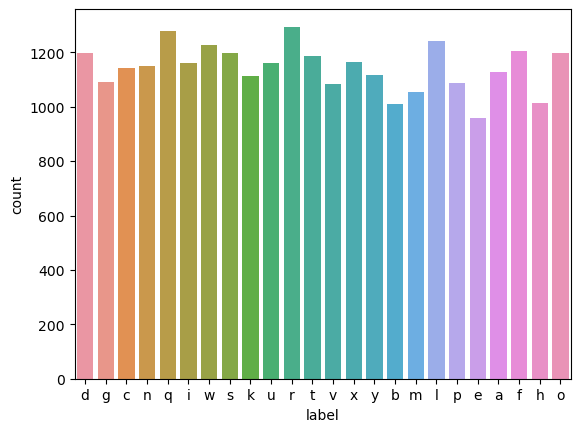

In [55]:
import seaborn as sns

alpha_labels = train_df.label.apply(lambda x: alpha_dict[x])
sns.countplot(x=alpha_labels)

In [92]:
# creating the custom dataset class

class CustomSignDataset(Dataset):
    def __init__(self, img, label):
        
        self.classes = np.array(label)
#         img = img /255.0

        self.img = np.array(img).reshape(-1,28,28,1)
        
        self.transform = Transforms.Compose([Transforms.ToTensor()])

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        
        label = self.classes[index]
        img = self.img[index]
        
        img = self.transform(img)
        label= torch.LongTensor([label])
        img = img.float()

        
        return img,label

In [93]:
train_set = CustomSignDataset(train_df.drop(['label'], axis=1), train_df['label'])
test_set = CustomSignDataset(test_df.drop(['label'], axis=1), test_df['label'])

In [94]:
# show a single image
def show_image(img, label, dataset):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {dataset.classes[label]}\nAlpha Label: {alpha_dict[dataset.classes[label]]}")


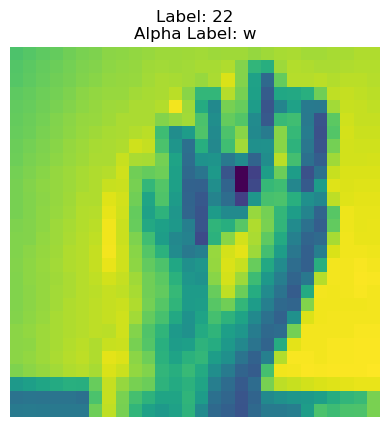

In [95]:
show_image(train_set.img[4],train_set.classes[4] ,train_set)

In [96]:
BATCH_SIZE = 32
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle= True)
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle= True)


In [112]:
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1]))

In [115]:
class SignModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      padding=1),
            
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.layer_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, 
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x


In [118]:
num_classes = len(alpha_dict)


In [ ]:
# setting agnostic device
